# Dataset & Noise

First we observe the visual feature of our dataset and the effect of our noise on the dataset

ORL Dataset


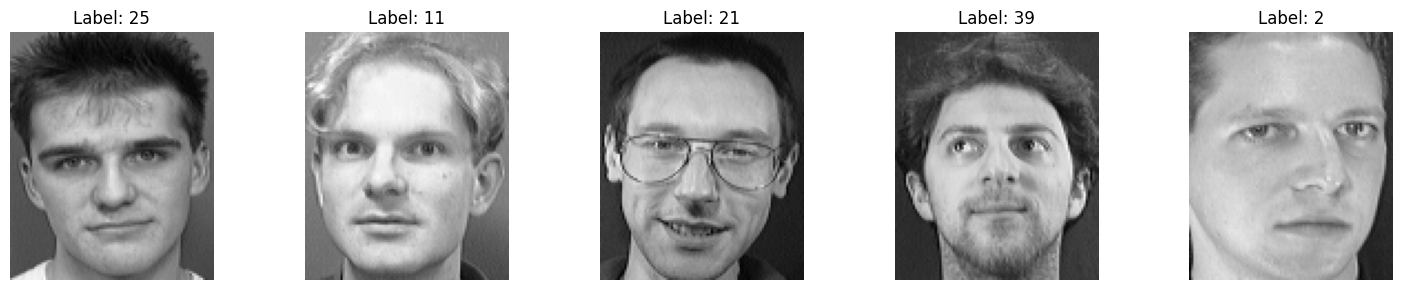

ORL Dataset (With Noise)


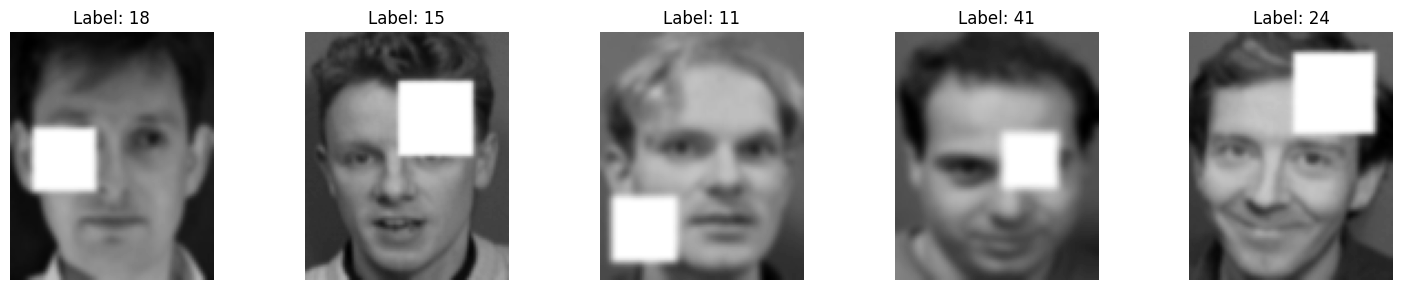

YaleB Dataset


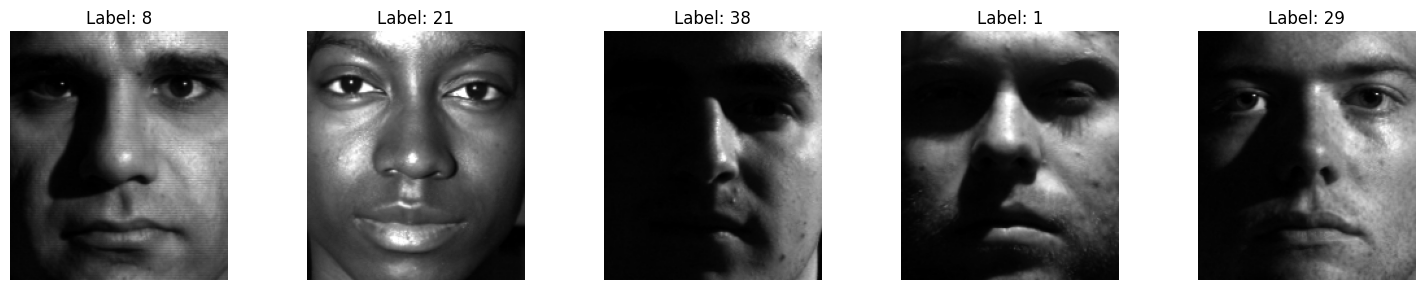

YaleB Dataset(With Noise)


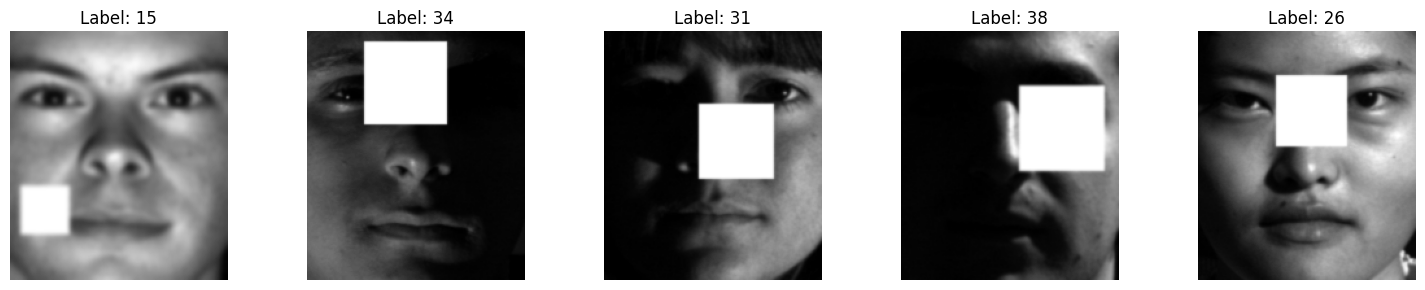

In [26]:
from preprocessing.noise import BlockNoise, BlurNoise
from utils.visualization import sample_and_plot_images
from preprocessing.load_data import load_image_data

block_noise_p100 = BlockNoise(mean=0.35, std=0.05, prob=1)
blur_noise_p100 = BlurNoise(mean=1, std=0.5, prob=1)

_, image_labels, image_objects = load_image_data('./data/ORL', noise_functions=[])
print("ORL Dataset")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/ORL', noise_functions=[block_noise_p100, blur_noise_p100])
print("ORL Dataset (With Noise)")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/CroppedYaleB', noise_functions=[])
print("YaleB Dataset")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/CroppedYaleB', noise_functions=[block_noise_p100, blur_noise_p100])
print("YaleB Dataset(With Noise)")
sample_and_plot_images(image_objects, image_labels)


# Set up Experiment
Set up the experiment with the following parameters options, with each combination we will run 5 experiments.
* nmf: the algorithm used
* datatset: the dataset used
* noises: the noise functions applied

In [27]:
from typing import Optional
from dataclasses import dataclass, asdict
from utils.visualization import plot_reconstructed_images

from preprocessing.noise import BlockNoise, BlurNoise
from preprocessing.custom_preprocess import ImagePreprocessor
from preprocessing.load_data import load_image_data
from algorithms.gpu import MultiplicativeUpdateNMF, RobustNMF, SparseNMF

@dataclass
class ExperimentParam:
    nmf: str # 'multiplicative_update' | 'robust' | 'sparse'
    dataset: str # 'yaleB' | 'orl'
    noises: list # ['block_noise', 'blur_noise']
    noise_p: float # noise probability
    hyper_param: Optional[dict] # hyper-parameters for the algorithm

class Experiment:
    def __init__(self, param: ExperimentParam):
        self.param = param


    def run(self, run_name: str):
        # set up
        preprocessor = ImagePreprocessor(max_size=2_400)

        # noise
        noises = []
        if "block_noise" in self.param.noises:
            block_noise = BlockNoise(mean=0.35, std=0.05, prob=self.param.noise_p)
            noises.append(block_noise)
        if "blur_noise" in self.param.noises:
            blur_noise = BlurNoise(mean=1, std=0.5, prob=self.param.noise_p)
            noises.append(blur_noise)

        # load data
        data_path = './data/CroppedYaleB' if self.param.dataset == 'yaleB' else './data/ORL'
        image_data, image_labels, image_objects = load_image_data(
            data_path,
            preprocess_function=preprocessor.preprocess,
            noise_functions=noises,
            data_fraction=0.9,
        )

        # run NMF algorithms
        if self.param.nmf == 'multiplicative_update':
            nmf_object = MultiplicativeUpdateNMF(
                V=image_data.T,
                num_features=50,
                max_iters=5000,
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        elif self.param.nmf == 'robust':
            nmf_object = RobustNMF(
                V=image_data.T,
                num_features=50,
                max_iters=8_000,
                lambda_param=self.param.hyper_param['lambda'],
                start_learning_rate=0.0003,
                end_learning_rate=0.000005,
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        elif self.param.nmf == 'sparse':
            nmf_object = SparseNMF(
                V=image_data.T,
                num_features=50,
                max_iters=5000,
                alpha=self.param.hyper_param['alpha'],
                beta=self.param.hyper_param['beta']
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        else:
            raise ValueError("nmf must be one of 'multiplicative_update', 'robust', 'sparse'")

        

        # collect metrics
        metrics = nmf_object.evaluate(image_labels)
        reconstructed_images_path = plot_reconstructed_images(nmf_object.get_reconstruction().T, image_objects, preprocessor, save_only=True, name=run_name, num_samples=10)

        return {
            "name": run_name,
            "param": asdict(self.param),
            "metrics": metrics,
            "reconstructed_images_path": reconstructed_images_path,
        }



# Run Experiments

We set up list of combination of parameter to test out, also we implement checkpoint to save our experience result to csv file for futher investigation

In [28]:
import pandas as pd
import os

def save_results(results, path):
    # Convert to DataFrame
    df = pd.DataFrame(results)
    df.to_csv(path, index=False)

# Function to check if an experiment has already been executed
def is_experiment_done(name: str, path='./results.csv') -> bool:
    # Check if the results file exists
    if not os.path.exists(path):
        return False
    
    # Load the existing results
    df = pd.read_csv(path)
    
    # Check if the experiment name is already in the results
    return name in df['name'].values

def flatten_dict(d, parent_key='', sep='_'):
    """
    Flattens a nested dictionary.

    :param d: The dictionary to flatten.
    :param parent_key: Used internally to build the key for the flattened dict.
    :param sep: The separator to use between concatenated keys.
    :return: A flattened dictionary.
    """
    items = {}
    for k, v in d.items():
        new_key = f"{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items


nmfs = ['robust', 'sparse', 'multiplicative_update']
datasets = ['yaleB', 'orl']
noise_ps = [0, 0.15, 0.4, 0.7, 1]
hyper_params = {
    'robust': [
        {'lambda': 0.5},
        {'lambda': 0.8},
        {'lambda': 1},
    ],
    'sparse': [
        {'alpha': 0.5, 'beta': 0.5},
        {'alpha': 0.8, 'beta': 0.8},
        {'alpha': 1, 'beta': 1},
    ],
    'multiplicative_update': [{'none': 0}],
}

results = []

# Check if results.csv exists, if so, load previous results
if os.path.exists('./results.csv'):
    df_prev = pd.read_csv('./results.csv')
    results = df_prev.to_dict('records')
    
for dataset in datasets:
    for noise_p in noise_ps:
        for nmf in nmfs:
            for hyper_param in hyper_params[nmf]:
                param = ExperimentParam(
                    nmf=nmf,
                    dataset=dataset,
                    noises=['block_noise', 'blur_noise'],
                    noise_p=noise_p,
                    hyper_param=hyper_param,
                )

                print("\n\n=====================================")
                print("Running experiment with param:")
                print(param)

                for i in range(5):
                    experiment_name = f"{nmf}_{dataset}_{int(noise_p * 100)}_{int(list(hyper_param.values())[0]*10)}_{i}"
                    if is_experiment_done(experiment_name):
                        print(f"Experiment {experiment_name} has already been executed. Skipping...")
                        continue

                    experiment = Experiment(param)
                    result = experiment.run(experiment_name)
                    results.append(flatten_dict(result))

                if len(results) > 0:
                    save_results(results, './results.csv')



Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'lambda': 0.5})
Experiment robust_yaleB_0_5_0 has already been executed. Skipping...
Experiment robust_yaleB_0_5_1 has already been executed. Skipping...
Experiment robust_yaleB_0_5_2 has already been executed. Skipping...
Experiment robust_yaleB_0_5_3 has already been executed. Skipping...
Experiment robust_yaleB_0_5_4 has already been executed. Skipping...


Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'lambda': 0.8})
Experiment robust_yaleB_0_8_0 has already been executed. Skipping...
Experiment robust_yaleB_0_8_1 has already been executed. Skipping...
Experiment robust_yaleB_0_8_2 has already been executed. Skipping...
Experiment robust_yaleB_0_8_3 has already been executed. Skipping...
Experiment robust_yaleB_0_8_4 has already been executed. Skippi

SparseNMF Progress:  49%|████▉     | 2445/5000 [00:08<00:09, 281.62it/s, Status=Early Stopping, Reconstruction RMSE=0.106, Cost Function=2.09e+5, W Regularization=1.08e+4, H Regularization=1.08e+4]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  44%|████▍     | 2196/5000 [00:07<00:09, 285.91it/s, Status=Early Stopping, Reconstruction RMSE=0.108, Cost Function=2.15e+5, W Regularization=1.05e+4, H Regularization=1.05e+4]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  57%|█████▋    | 2873/5000 [00:09<00:06, 318.54it/s, Status=Early Stopping, Reconstruction RMSE=0.107, Cost Function=1.92e+5]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 0.5})


RobustNMF Progress:  83%|████████▎ | 6639/8000 [00:32<00:06, 203.83it/s, Status=Early Stopping, Reconstruction RMSE=0.101, Cost Function=1.8e+5, ||Error Matrix||=952]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 0.8})


RobustNMF Progress:  82%|████████▏ | 6565/8000 [00:31<00:06, 205.64it/s, Status=Early Stopping, Reconstruction RMSE=0.101, Cost Function=1.81e+5, ||Error Matrix||=3.7]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 1})


RobustNMF Progress:  76%|███████▌  | 6070/8000 [00:30<00:09, 200.23it/s, Status=Early Stopping, Reconstruction RMSE=0.0999, Cost Function=1.8e+5, ||Error Matrix||=0]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  55%|█████▌    | 2764/5000 [00:09<00:07, 304.79it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=2.06e+5, W Regularization=1.1e+4, H Regularization=1.1e+4]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  53%|█████▎    | 2660/5000 [00:08<00:07, 300.02it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=2.13e+5, W Regularization=1.1e+4, H Regularization=1.1e+4]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  50%|████▉     | 2483/5000 [00:08<00:08, 308.41it/s, Status=Early Stopping, Reconstruction RMSE=0.11, Cost Function=2.19e+5, W Regularization=1.07e+4, H Regularization=1.07e+4]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  72%|███████▏  | 3579/5000 [00:11<00:04, 318.45it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=1.95e+5]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 0.5})


RobustNMF Progress:  82%|████████▏ | 6558/8000 [00:32<00:07, 203.07it/s, Status=Early Stopping, Reconstruction RMSE=0.103, Cost Function=1.85e+5, ||Error Matrix||=1.04e+3]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 0.8})


RobustNMF Progress:  77%|███████▋  | 6171/8000 [00:30<00:08, 204.96it/s, Status=Early Stopping, Reconstruction RMSE=0.103, Cost Function=1.84e+5, ||Error Matrix||=3]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 1})


RobustNMF Progress:  78%|███████▊  | 6234/8000 [00:30<00:08, 203.39it/s, Status=Early Stopping, Reconstruction RMSE=0.103, Cost Function=1.85e+5, ||Error Matrix||=0]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  58%|█████▊    | 2877/5000 [00:09<00:07, 294.22it/s, Status=Early Stopping, Reconstruction RMSE=0.111, Cost Function=2.09e+5, W Regularization=1.11e+4, H Regularization=1.11e+4]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  53%|█████▎    | 2654/5000 [00:08<00:07, 294.98it/s, Status=Early Stopping, Reconstruction RMSE=0.112, Cost Function=2.17e+5, W Regularization=1.09e+4, H Regularization=1.09e+4]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  48%|████▊     | 2376/5000 [00:08<00:08, 292.06it/s, Status=Early Stopping, Reconstruction RMSE=0.113, Cost Function=2.22e+5, W Regularization=1.05e+4, H Regularization=1.05e+4]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='yaleB', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  68%|██████▊   | 3410/5000 [00:10<00:04, 327.68it/s, Status=Early Stopping, Reconstruction RMSE=0.111, Cost Function=1.98e+5]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'lambda': 0.5})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:22<00:00, 357.14it/s, Reconstruction RMSE=0.159, Cost Function=5.27e+4, ||Error Matrix||=274]    




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'lambda': 0.8})


RobustNMF Progress:  99%|█████████▉| 7952/8000 [00:22<00:00, 360.66it/s, Status=Early Stopping, Reconstruction RMSE=0.156, Cost Function=5.15e+4, ||Error Matrix||=0.211]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'lambda': 1})


RobustNMF Progress:  99%|█████████▉| 7902/8000 [00:22<00:00, 344.62it/s, Status=Early Stopping, Reconstruction RMSE=0.158, Cost Function=5.22e+4, ||Error Matrix||=0]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  40%|████      | 2024/5000 [00:05<00:08, 353.37it/s, Status=Early Stopping, Reconstruction RMSE=0.111, Cost Function=3.99e+4, W Regularization=4.45e+3, H Regularization=4.45e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  16%|█▌        | 778/5000 [00:02<00:12, 346.26it/s, Status=Early Stopping, Reconstruction RMSE=0.115, Cost Function=4.37e+4, W Regularization=4.23e+3, H Regularization=4.23e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  12%|█▏        | 603/5000 [00:01<00:14, 308.48it/s, Status=Early Stopping, Reconstruction RMSE=0.12, Cost Function=4.65e+4, W Regularization=3.93e+3, H Regularization=3.93e+3]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  66%|██████▋   | 3316/5000 [00:08<00:04, 368.77it/s, Status=Early Stopping, Reconstruction RMSE=0.11, Cost Function=3.5e+4]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'lambda': 0.5})


RobustNMF Progress: 100%|█████████▉| 7987/8000 [00:25<00:00, 314.27it/s, Status=Early Stopping, Reconstruction RMSE=0.16, Cost Function=5.29e+4, ||Error Matrix||=332]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'lambda': 0.8})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:25<00:00, 319.88it/s, Reconstruction RMSE=0.159, Cost Function=5.25e+4, ||Error Matrix||=0.712] 




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'lambda': 1})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:25<00:00, 311.96it/s, Reconstruction RMSE=0.157, Cost Function=5.19e+4, ||Error Matrix||=0]      




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  38%|███▊      | 1919/5000 [00:05<00:09, 323.96it/s, Status=Early Stopping, Reconstruction RMSE=0.111, Cost Function=3.99e+4, W Regularization=4.4e+3, H Regularization=4.4e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  18%|█▊        | 904/5000 [00:02<00:12, 322.73it/s, Status=Early Stopping, Reconstruction RMSE=0.115, Cost Function=4.39e+4, W Regularization=4.23e+3, H Regularization=4.23e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  13%|█▎        | 664/5000 [00:02<00:15, 271.69it/s, Status=Early Stopping, Reconstruction RMSE=0.119, Cost Function=4.63e+4, W Regularization=3.97e+3, H Regularization=3.97e+3]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.15, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  60%|█████▉    | 2978/5000 [00:08<00:05, 354.93it/s, Status=Early Stopping, Reconstruction RMSE=0.11, Cost Function=3.52e+4]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'lambda': 0.5})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:25<00:00, 318.54it/s, Reconstruction RMSE=0.16, Cost Function=5.29e+4, ||Error Matrix||=349]     




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'lambda': 0.8})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:25<00:00, 314.26it/s, Reconstruction RMSE=0.159, Cost Function=5.23e+4, ||Error Matrix||=0.284] 




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'lambda': 1})


RobustNMF Progress:  99%|█████████▉| 7931/8000 [00:24<00:00, 321.22it/s, Status=Early Stopping, Reconstruction RMSE=0.158, Cost Function=5.22e+4, ||Error Matrix||=0]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  49%|████▊     | 2427/5000 [00:07<00:07, 338.79it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=3.93e+4, W Regularization=4.48e+3, H Regularization=4.47e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  16%|█▋        | 821/5000 [00:02<00:13, 318.88it/s, Status=Early Stopping, Reconstruction RMSE=0.113, Cost Function=4.31e+4, W Regularization=4.26e+3, H Regularization=4.26e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  13%|█▎        | 653/5000 [00:02<00:14, 291.83it/s, Status=Early Stopping, Reconstruction RMSE=0.119, Cost Function=4.62e+4, W Regularization=4e+3, H Regularization=4e+3]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.4, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  67%|██████▋   | 3329/5000 [00:09<00:04, 350.89it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=3.47e+4]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 0.5})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:24<00:00, 326.19it/s, Reconstruction RMSE=0.162, Cost Function=5.35e+4, ||Error Matrix||=412]    




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 0.8})


RobustNMF Progress:  99%|█████████▉| 7933/8000 [00:24<00:00, 328.11it/s, Status=Early Stopping, Reconstruction RMSE=0.159, Cost Function=5.25e+4, ||Error Matrix||=0.374]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'lambda': 1})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:24<00:00, 323.00it/s, Reconstruction RMSE=0.156, Cost Function=5.17e+4, ||Error Matrix||=0]      




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  49%|████▉     | 2472/5000 [00:07<00:07, 329.77it/s, Status=Early Stopping, Reconstruction RMSE=0.106, Cost Function=3.82e+4, W Regularization=4.48e+3, H Regularization=4.47e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  17%|█▋        | 842/5000 [00:02<00:13, 307.64it/s, Status=Early Stopping, Reconstruction RMSE=0.109, Cost Function=4.17e+4, W Regularization=4.23e+3, H Regularization=4.23e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  12%|█▏        | 611/5000 [00:02<00:15, 278.74it/s, Status=Early Stopping, Reconstruction RMSE=0.113, Cost Function=4.44e+4, W Regularization=3.97e+3, H Regularization=3.97e+3]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=0.7, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  59%|█████▉    | 2950/5000 [00:07<00:05, 368.89it/s, Status=Early Stopping, Reconstruction RMSE=0.106, Cost Function=3.37e+4]




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 0.5})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:25<00:00, 319.39it/s, Reconstruction RMSE=0.158, Cost Function=5.22e+4, ||Error Matrix||=344]    




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 0.8})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:23<00:00, 334.28it/s, Reconstruction RMSE=0.157, Cost Function=5.2e+4, ||Error Matrix||=1.73]   




Running experiment with param:
ExperimentParam(nmf='robust', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'lambda': 1})


RobustNMF Progress: 100%|██████████| 8000/8000 [00:24<00:00, 327.60it/s, Reconstruction RMSE=0.154, Cost Function=5.11e+4, ||Error Matrix||=0]       




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 0.5, 'beta': 0.5})


SparseNMF Progress:  45%|████▌     | 2269/5000 [00:06<00:08, 337.62it/s, Status=Early Stopping, Reconstruction RMSE=0.102, Cost Function=3.72e+4, W Regularization=4.48e+3, H Regularization=4.48e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 0.8, 'beta': 0.8})


SparseNMF Progress:  18%|█▊        | 898/5000 [00:02<00:12, 328.69it/s, Status=Early Stopping, Reconstruction RMSE=0.107, Cost Function=4.12e+4, W Regularization=4.23e+3, H Regularization=4.23e+3]




Running experiment with param:
ExperimentParam(nmf='sparse', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'alpha': 1, 'beta': 1})


SparseNMF Progress:  13%|█▎        | 645/5000 [00:02<00:15, 278.18it/s, Status=Early Stopping, Reconstruction RMSE=0.111, Cost Function=4.36e+4, W Regularization=3.98e+3, H Regularization=3.98e+3]




Running experiment with param:
ExperimentParam(nmf='multiplicative_update', dataset='orl', noises=['block_noise', 'blur_noise'], noise_p=1, hyper_param={'none': 0})


MultiplicativeUpdateNMF Progress:  75%|███████▌  | 3756/5000 [00:10<00:03, 373.93it/s, Status=Early Stopping, Reconstruction RMSE=0.101, Cost Function=3.22e+4]
